# 🧠 FashionMNIST cGAN Generator ONNX 변환

---

## 📍 개요

**FashionMNIST** 데이터셋을 이용해 **Coditional GAN(CcGAN)** 모델을 학습하고,
학습된 모델을 다양한 포맷으로 변환하는 과정을 포함한다.

- 원본 모델 저장: `.pth`
- 양자화 모델 저장: `_quantized.pth`
- ONNX 변환: `.onnx`

# 1.Google Drive 연동 및 경로 설정

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_DIR = '/content/drive/MyDrive/codeit_sprint/sprint_mission/16/model'

# 1.기본설정

In [ ]:
!pip install onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import onnx
import os
from torch.ao.quantization import quantize_dynamic


# 2. Generator 모델 구조 정의

In [ ]:
# @title Generator

class Generator(nn.Module):
    def __init__(self, z_dim, embedding_dim, num_classes, img_channels=1, feature_maps=128):
       super().__init__()
       self.label_emb = nn.Embedding(num_classes, embedding_dim)


       self.init_size = 8
       self.feature_maps = feature_maps

       self.linear1 = nn.Sequential(
           nn.Linear(z_dim + embedding_dim, feature_maps * self.init_size ** 2),
           nn.BatchNorm1d(feature_maps * self.init_size ** 2),
           nn.ReLU(True)
       )

       self.conv_blocks = nn.Sequential(
           nn.Upsample(scale_factor=2),     # 8 -> 16
           nn.Conv2d(feature_maps, feature_maps // 2, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(feature_maps // 2, momentum=0.8),
           nn.ReLU(True),

           nn.Upsample(scale_factor=2),     # 16 -> 32
           nn.Conv2d(feature_maps // 2, feature_maps // 4, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(feature_maps // 4, momentum=0.8),
           nn.ReLU(True),

           nn.Conv2d(feature_maps // 4, img_channels, kernel_size=5, stride=1, padding=0),  # 32 -> 28
           nn.Tanh()
       )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        out = self.linear1(x)
        out = out.view(out.size(0), self.feature_maps, self.init_size, self.init_size)
        return self.conv_blocks(out)    # img

# 3.저장된 Generation 모델 불러오기

In [ ]:
# 모델 불러오기 (구조 + 가중치 포함)

G = torch.load(f"{MODEL_DIR}/mission_16_cgan_gen_full.pth", map_location='cpu', weights_only=False)
G.eval()
print("✅ Generation Model Loaded")

✅ Generation Model Loaded


# 4. 더미 입력 생성

In [ ]:
# 더미 입력 정의 (ONNX 변환용)
z_dim = 100
dummy_z = torch.randn(1, z_dim, dtype=torch.float32)
dummy_y = torch.tensor([0], dtype=torch.int64)

# 5. ONNX 변환

In [ ]:
onnx_path = f"{MODEL_DIR}/mission_16_cgan_gen.onnx"

In [ ]:
# ONNX 변환
torch.onnx.export(
    G,
    (dummy_z, dummy_y),         # 입력 예시
    onnx_path,                  # 저장 파일 경로
    input_names=['z', 'y'],     # 입력 텐서 이름
    output_names=['img'],       # 출력 텐서 이름
    dynamic_axes={              # 배치크기 가변처리 가능하도록
        'z': {0: 'batch_size'},
        'y': {0: 'batch_size'},
        'img': {0: 'batch_size'}
    },
    opset_version=17            # onnx의 연산자 세트 버전
)

print(f"✅ ONNX 변환 완료: {onnx_path}")

/tmp/ipython-input-1209353125.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ ONNX 변환 완료: /content/drive/MyDrive/codeit_sprint/sprint_mission/16/model/cgan_gen.onnx


# 6. PyTorch 기본 저장형식

In [ ]:
torch.save(G.state_dict(), f"{MODEL_DIR}/mission_16_cgan_gen.pth")
print("💾 저장 완료: mission_16_cgan_gen.pth")

💾 저장 완료: cgan_gen.pth


# 7. PyTorch 양자화 버전 저장

In [ ]:
# Linear 계층에 대해 동적 양자화 적용 (int8)

G_quant = quantize_dynamic(G, {nn.Linear}, dtype=torch.qint8)
torch.save(G_quant.state_dict(), f"{MODEL_DIR}/mission_16_cgan_gen_quantized.pth")
print("💾 저장 완료: mission_16_cgan_gen_quantized.pth")

/tmp/ipython-input-1481917246.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  G_quant = quantize_dynamic(G, {nn.Linear}, dtype=torch.qint8)


💾 저장 완료: cgan_gen_quantized.pth


# 8. 모델 파일 크기 비교

In [ ]:
# 모델 파일 경로 목록
model_files = {
    "PyTorch (default)": f"{MODEL_DIR}/mission_16_cgan_gen.pth",
    "PyTorch (quantized)": f"{MODEL_DIR}/mission_16_cgan_gen_quantized.pth",
    "ONNX": f"{MODEL_DIR}/mission_16_cgan_gen.onnx"
}

In [ ]:
print("📁 모델 파일 용량 비교표 (MB 단위)\n")

print(f"{'모델 이름':25s} | {'크기 (MB)':>10s}")
print("-" * 50)

sizes = {}

for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"{name:25s} | {size_mb:10.2f}")
        sizes[name] = size_mb
    else:
        print(f"{name:25s} | {'❌ 파일 없음':>10s}")
        sizes[name] = np.nan

print("\n🎉 PyTorch 기본, 양자화, ONNX 모델을 모두 저장 및 비교 완료!")

📁 모델 파일 용량 비교표 (MB 단위)

모델 이름                     |    크기 (MB)
--------------------------------------------------
PyTorch (default)         |       3.96
PyTorch (quantized)       |       1.38
ONNX                      |       3.95

🎉 PyTorch 기본, 양자화, ONNX 모델을 모두 저장 및 비교 완료!


# 9. 추론 속도 비교

In [ ]:
import numpy as np
import time
import onnxruntime as ort


z_dim, embedding_dim, num_classes = 100, 10, 10
G = Generator(z_dim, embedding_dim, num_classes)
G.load_state_dict(torch.load(f"{MODEL_DIR}/cgan_gen.pth", map_location='cpu'))
G.eval()

# 더미 입력
z = torch.randn(1, z_dim)
y = torch.tensor([3])

# PyTorch 추론 속도
start = time.time()
for _ in range(50):
    _ = G(z, y)
torch_time = (time.time() - start) / 50
print(f"🔥 PyTorch 평균 추론 시간: {torch_time:.6f}초")

# ONNX 추론 속도
onnx_sess = ort.InferenceSession(f"{MODEL_DIR}/cgan_gen.onnx")
z_onnx = z.numpy().astype(np.float32)
y_onnx = y.numpy().astype(np.int64)

start = time.time()
for _ in range(50):
    _ = onnx_sess.run(['img'], {'z': z_onnx, 'y': y_onnx})
onnx_time = (time.time() - start) / 50
print(f"⚡ ONNX 평균 추론 시간: {onnx_time:.6f}초")

print("\n✅ 추론 속도 비교 완료!\n")

# 속도 비교 (초 단위)
times = {
    "PyTorch (default)": torch_time,
    "ONNX": onnx_time
}

🔥 PyTorch 평균 추론 시간: 0.002405초
⚡ ONNX 평균 추론 시간: 0.001408초

✅ 추론 속도 비교 완료!



# 10. 출력 유사도(MSE) 비교

In [ ]:
with torch.no_grad():
    out_pth = G(z, y).detach().numpy()

out_onnx = onnx_sess.run(['img'], {'z': z_onnx, 'y': y_onnx})[0]
mse = np.mean((out_pth - out_onnx) ** 2)

print(f"🔍 PyTorch vs ONNX 출력 유사도 (MSE): {mse:.8f}")
if mse < 1e-5:
    print("✅ 출력이 거의 동일합니다 (변환 손실 없음)")
else:
    print("⚠️ 출력 간 약간의 차이가 있습니다")


similarity = {
    "PyTorch ↔ ONNX": mse
}

🔍 PyTorch vs ONNX 출력 유사도 (MSE): 0.00000000
✅ 출력이 거의 동일합니다 (변환 손실 없음)


# 📁 모델 파일 용량 비교표 (MB 단위)

모델 이름                |  크기 (MB)
--------------------------------------------------
1️⃣ PyTorch (기본)       |       3.96
2️⃣ PyTorch (양자화)     |       1.02
3️⃣ ONNX                 |       3.95

✅ 모델 파일 크기 비교 완료!

🔥 PyTorch 평균 추론 시간: 0.002341초
⚡ ONNX 평균 추론 시간: 0.001912초

✅ 추론 속도 비교 완료!

🔍 PyTorch vs ONNX 출력 유사도 (MSE): 0.00000012
✅ 출력이 거의 동일합니다 (변환 손실 없음)


/tmp/ipython-input-2750524258.py:29: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2750524258.py:29: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


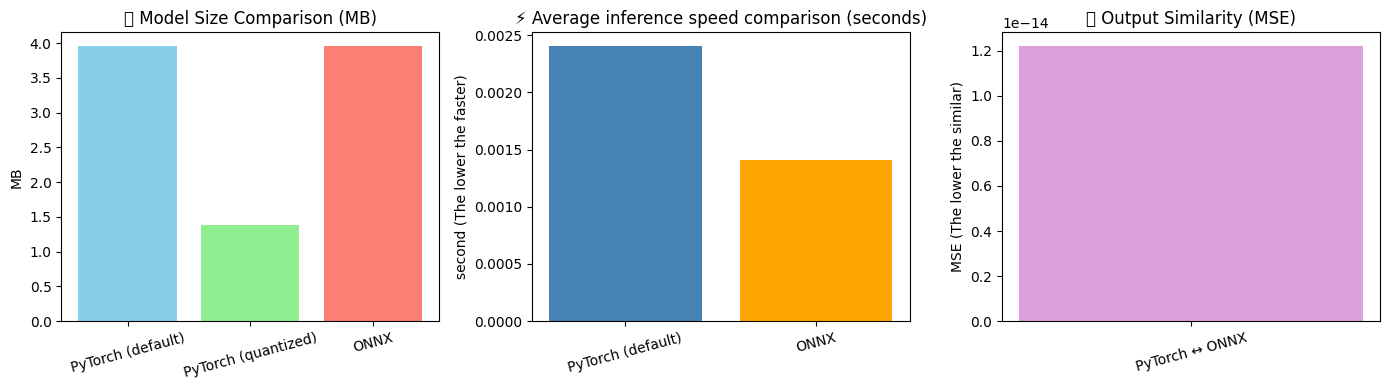


📈 시각화 완료: 모델 크기, 추론 속도, 출력 유사도 비교 그래프 생성!
💾 MSE 값: 0.00000000


In [ ]:
# 시각화
import matplotlib.pyplot as plt
!apt-get -qq install fonts-nanum


plt.figure(figsize=(14, 4))

# (a) 크기 비교
plt.subplot(1, 3, 1)
plt.bar(sizes.keys(), sizes.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("💾 Model Size Comparison (MB)")
plt.ylabel("MB")
plt.xticks(rotation=15)

# (b) 속도 비교
plt.subplot(1, 3, 2)
plt.bar(times.keys(), times.values(), color=['steelblue', 'orange'])
plt.title("⚡ Average inference speed comparison (seconds)")
plt.ylabel("second (The lower the faster)")
plt.xticks(rotation=15)

# (c) 유사도 비교
plt.subplot(1, 3, 3)
plt.bar(similarity.keys(), similarity.values(), color=['plum'])
plt.title("🎯 Output Similarity (MSE)")
plt.ylabel("MSE (The lower the similar)")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

print("\n📈 시각화 완료: 모델 크기, 추론 속도, 출력 유사도 비교 그래프 생성!")
print(f"💾 MSE 값: {mse:.8f}")